In [1]:
import pandas as pd
import numpy as np
import regex as re
import igraph
import sys
from pytictoc import TicToc
import statistics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from igraph import Graph

In [2]:
time=TicToc()

In [5]:
y_vector_df = pd.read_csv("data/vectorDF.csv")
DAG = pd.read_csv("data/ruleBased_DAGs.csv",sep =',')
features = pd.read_csv("data/aggFeatures.csv",sep =',')

In [6]:
DAG = pd.merge(DAG, features, how='inner', left_on = 'job_name', right_on = 'job_name')
DAG.drop('Unnamed: 0', axis=1)
DAG = DAG[DAG.job_name.isin(y_vector_df.job_name)]

In [7]:
DAG['groupSize'] = DAG.groupby('group')['group'].transform('size')
DAG = DAG[DAG.groupSize > 2]

In [8]:
DAG = DAG.sort_values("totalStart", ascending=True)

In [9]:
DAG.corr().run_time

Unnamed: 0          -0.002432
totalStart          -0.047840
totalEnd            -0.045403
run_time             1.000000
nNodes               0.178489
IfMins              -0.020601
IfHours             -0.027012
IfDays               0.069643
mutable                   NaN
group                0.057207
instance_num_mean    0.296019
plan_cpu_mean       -0.168357
plan_mem_mean        0.072516
instance_num_sum     0.332102
plan_cpu_sum         0.050232
plan_mem_sum         0.184384
instance_num_max     0.271172
plan_cpu_max        -0.118089
plan_mem_max         0.154511
instance_num_var     0.122272
plan_cpu_var         0.026709
plan_mem_var         0.135670
groupSize           -0.069307
Name: run_time, dtype: float64

In [10]:
groupList = DAG['group'].unique().tolist()

In [11]:
### prediction using var of graph level attributes 
mselist_var = []
maelist_var = []
predicated_var = []
real_var = []
time.tic()
for gr in groupList:
    temp = DAG[DAG.group==gr]
    X_train, X_test, y_train, y_test = train_test_split(temp[['plan_cpu_var', 'plan_mem_var', 'instance_num_var']], temp[['run_time']], test_size=0.0001, shuffle=False)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred_var = regr.predict(X_test)
    predicated_var.append(y_pred_var.flatten()[0])
    real_var.append(y_test.iloc[0]['run_time'])
    mselist_var.append(mean_squared_error(y_test, y_pred_var)) 
    maelist_var.append(mean_absolute_error(y_test, y_pred_var)) 
time.toc()

Elapsed time is 155.774369 seconds.


In [13]:
### prediction using MAX of graph level attributes 
mselist_max = []
maelist_max = []
predicated_max = []
time.tic()
for gr in groupList:
    temp = DAG[DAG.group==gr]
    X_train, X_test, y_train, y_test = train_test_split(temp[['plan_cpu_max', 'plan_mem_max', 'instance_num_max']], temp[['run_time']], test_size=0.00001, shuffle=False)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred_max = regr.predict(X_test)
    predicated_max.append(y_pred_max.flatten()[0])
    mselist_max.append(mean_squared_error(y_test, y_pred_max)) 
    maelist_max.append(mean_absolute_error(y_test, y_pred_max)) 
time.toc()



Elapsed time is 154.354709 seconds.


In [14]:
### prediction using sum of graph level attributes 
maelist_sum = []
mselist_sum = []
predicated_sum = []
time.tic()
for gr in groupList:
    temp = DAG[DAG.group==gr]
    X_train, X_test, y_train, y_test = train_test_split(temp[['instance_num_sum', 'plan_cpu_sum', 'plan_mem_sum']], temp[['run_time']], test_size=0.00001, shuffle=False)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred_sum = regr.predict(X_test)
    predicated_sum.append(y_pred_sum.flatten()[0])
    mselist_sum.append(mean_squared_error(y_test, y_pred_sum)) 
    maelist_sum.append(mean_absolute_error(y_test, y_pred_sum)) 
time.toc()

Elapsed time is 154.381356 seconds.


In [15]:
### prediction using mean of graph level attributes 
mselist_mean = []
maelist_mean = []
predicated_mean = []
time.tic()
for gr in groupList:
    temp = DAG[DAG.group==gr]
    X_train, X_test, y_train, y_test = train_test_split(temp[['instance_num_mean', 'plan_cpu_mean', 'plan_mem_mean']], temp[['run_time']], test_size=0.00001, shuffle=False)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred_mean = regr.predict(X_test)
    predicated_mean.append(y_pred_mean.flatten()[0])
    mselist_mean.append(mean_squared_error(y_test, y_pred_mean)) 
    maelist_mean.append(mean_absolute_error(y_test, y_pred_mean)) 
time.toc()


Elapsed time is 154.409179 seconds.


In [16]:
#### prediction using only group names
DAG['val'] = 1
r2list = []
mselist_pure = []
maelist_pure = []
predicated_nothing = []
time.tic()
for gr in groupList:
    temp = DAG[DAG.group==gr]
    X_train, X_test, y_train, y_test = train_test_split(temp[['val']], temp[['run_time']], test_size=0.00001, shuffle=False)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred_nothing = regr.predict(X_test)
    predicated_nothing.append(y_pred_nothing.flatten()[0])
    mselist_pure.append(mean_squared_error(y_test, y_pred_nothing)) 
    maelist_pure.append(mean_absolute_error(y_test, y_pred_nothing)) 
time.toc()



Elapsed time is 152.617531 seconds.


In [17]:
time.tic()
mselist_all_all = []
maelist_all_all = []
predicated_all = []
time.tic()
for gr in groupList:
    temp = DAG[DAG.group==gr]
    X_train, X_test, y_train, y_test = train_test_split(temp[['instance_num_mean', 'plan_cpu_mean', 'plan_mem_mean',
       'instance_num_sum', 'plan_cpu_sum', 'plan_mem_sum', 'instance_num_max',
       'plan_cpu_max', 'plan_mem_max', 'instance_num_var', 'plan_cpu_var',
       'plan_mem_var']], temp[['run_time']], test_size=0.00001, shuffle=False)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred_all = regr.predict(X_test)
    predicated_all.append(y_pred_all.flatten()[0])
    mselist_all_all.append(mean_squared_error(y_test, y_pred_all)) 
    maelist_all_all.append(mean_absolute_error(y_test, y_pred_all)) 
time.toc()



Elapsed time is 157.251077 seconds.


In [18]:

print("\nrun time variance using var of features")
print(mean_squared_error(real_var, predicated_var))
print(mean_absolute_error(real_var, predicated_var))

print("\nrun time variance using max of features")
print(mean_squared_error(real_var, predicated_max))
print(mean_absolute_error(real_var, predicated_max))

print("\nrun time variance using sum of features")
print(mean_squared_error(real_var, predicated_sum))
print(mean_absolute_error(real_var, predicated_sum))

print("\nrun time variance using mean of features")
print(mean_squared_error(real_var, predicated_mean))
print(mean_absolute_error(real_var, predicated_mean))

print("\nrun time variance using grup alone")
print(mean_squared_error(real_var, predicated_nothing))
print(mean_absolute_error(real_var, predicated_nothing))

print("\nrun time variance using all  features")
print(mean_squared_error(real_var, predicated_all))
print(mean_absolute_error(real_var, predicated_all))


run time variance using var of features
1.1276246887035183e+42
1.419327715903662e+19

run time variance using max of features
3.5554507879650317e+28
2286819344177.38

run time variance using sum of features
9.10033688404242e+32
760905289462581.6

run time variance using mean of features
8.287824277587524e+32
887612668508101.1

run time variance using grup alone
82521.85374116126
135.9989401848899

run time variance using all  features
2.029202590299085e+43
4.039845690223163e+19


In [19]:
print(mean_squared_error(real_var, predicated_var))

1.1276246887035183e+42


In [22]:
#visualising the results

cols = ['var','max','sum','mean','no','all','real']

visualDF = pd.DataFrame(list(zip(predicated_var, 
                        predicated_max,
                        predicated_sum,
                        predicated_mean,
                        predicated_nothing,
                        predicated_all,
                        real_var
                        )),columns = cols)

In [23]:
visualDF

,var,max,sum,mean,no,all,real
0,973.168332,970.246441,913.873515,913.873515,914.166667,733.622166,324
1,1043.119652,999.239582,1020.765683,1020.765683,909.272727,4098.773568,916
2,178.035424,169.294225,6.530891,6.530891,738.714286,6.000000,7
3,298.427146,339.547770,472.633405,472.633405,320.576923,478.309986,242
4,2153.620395,2109.814351,1795.151153,1795.151153,2333.363636,2181.989629,2174
...,...,...,...,...,...,...,...
17282,21.000000,21.000000,21.000000,21.000000,20.333333,21.000000,16
17283,13.000000,13.000000,13.000000,13.000000,60.000000,13.000000,13
17284,50.000000,50.000000,50.000000,50.000000,80.500000,50.000000,52
17285,120.390663,130.500000,162.613861,124.111344,130.500000,162.364100,115


In [24]:
visualDF['AE_var'] = abs(visualDF['var'] - visualDF['real'])
visualDF['AE_max'] = abs(visualDF['max'] - visualDF['real'])
visualDF['AE_sum'] = abs(visualDF['sum'] - visualDF['real'])
visualDF['AE_mean'] = abs(visualDF['mean'] - visualDF['real'])
visualDF['AE_no'] = abs(visualDF['no'] - visualDF['real'])
visualDF['AE_all'] = abs(visualDF['all'] - visualDF['real'])
boxdf = visualDF[['AE_var', 'AE_max' , 'AE_sum' , 'AE_mean' , 'AE_no' , 'AE_all' ]]

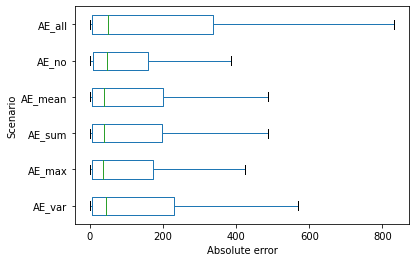

In [64]:
ax = boxdf.plot(kind='box',showfliers=False,vert=False)
ax.set_xlabel("Absolute error")
ax.set_ylabel("Scenario")
plt.show()

fig = ax.get_figure()


#fig.savefig("graphs/boxplot_rulebased.pdf", bbox_inches='tight')

In [25]:
y_pred_all.flatten()[0]

327.4835037491466

In [27]:
round(statistics.mean(mselist_all_all))

20292025902990845825625534775211391224643584

In [ ]:
#### First Checkpoint ######

In [44]:
#group of rule based classification analysis
DAy_vector_df = pd.read_csv("data/vectorDF.csv")
DAG = pd.read_csv("data/ruleBased_DAGs.csv",sep =',')
features = pd.read_csv("data/aggFeatures.csv",sep =',')
DAG['groupSize'] = DAG.groupby('group')['group'].transform('size')
temp = DAG[DAG.groupSize > 1]


In [45]:
#number of groups
print('#groups = ',len(set(temp.group)))
#mean of group size
group_size_node = temp.drop_duplicates(subset=['group'])

print('mean of group size = ', np.mean(group_size_node.groupSize))
print('percentage of grouped jobs = ', (len(temp)/len(DAG))*100)

#groups =  26980
mean of group size =  8.535618977020015
percentage of grouped jobs =  92.08840512484204


In [46]:
print('#jobs that are in 15 min. periods = ', len(temp[temp.IfMins == 1]))
(len(temp[temp.IfMins == 1]) / len(temp)) * 100

#jobs that are in 15 min. periods =  97233


42.221797638639806

In [47]:
print('#jobs that are in hourly periods = ', len(temp[temp.IfHours == 1]))
(len(temp[temp.IfHours == 1]) / len(temp)) * 100

#jobs that are in hourly periods =  115879


50.31851005901229

In [48]:
print('#jobs that are in 15 daily periods = ', len(temp[temp.IfDays == 1]))
(len(temp[temp.IfDays == 1]) / len(temp)) * 100

#jobs that are in 15 daily periods =  139445


60.55164986907868

In [49]:
group_size_node = temp.drop_duplicates(subset=['group'])

In [50]:
group_size_node.sort_values(by = ['groupSize'])

,Unnamed: 0,job_name,DAGs,totalStart,totalEnd,run_time,nNodes,IfMins,IfHours,IfDays,mutable,group,groupSize
35709,1728592,j_1795856,"5,14-§-5-§-13,3,6,10,1-§-3,8,13-§-7-§-9-§-12,9...",206206,206234,28,16,True,True,True,False,35709,2
59925,2890011,j_3004871,"14-§-3-§-4-§-5-§-6-§-7-§-8-§-9-§-10-§-11-§-13,...",669965,669970,5,16,True,False,True,False,22972,2
59942,2890967,j_3005999,"3-§-9-§-11-§-13,22-§-20-§-21,13-§-7-§-16-§-24,...",296689,296778,89,26,True,True,True,False,59942,2
59994,2894073,j_3009389,"3,12,9-§-8,4-§-3,10-§-5-§-9,7-§-2-§-6,8-§-7,5-...",563973,564327,354,14,True,True,True,False,59994,2
60012,2895173,j_3010586,"11-§-10,14-§-13,7-§-11,3-§-11,16-§-1-§-2-§-3-§...",440444,440588,144,18,True,True,True,False,60012,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,792,j_815,"3-§-2,9-§-8,10-§-9,5-§-4,4-§-1,2-§-1,1,6-§-1,8...",652447,652449,2,10,True,True,True,False,18,553
221,10477,j_10708,"2-§-1,5-§-4,10-§-9,3-§-2,8,4-§-3,9-§-8,6-§-5,1...",496089,496126,37,16,True,True,True,False,221,565
171,8176,j_8584,"2-§-1,12-§-11,13-§-12,3-§-2,10,5,9-§-2-§-4-§-5...",214572,214576,4,13,True,True,True,False,171,662
21,865,j_897,"10,2-§-1,7-§-6,4-§-3,1,6,5,11-§-7-§-9-§-10,9-§...",394843,395194,351,12,True,True,True,False,21,731


In [51]:
X = list (set(group_size_node.groupSize))
Y = []
for i in X:
    tempdf = group_size_node[group_size_node.groupSize == i]
    Y.append(np.mean(tempdf.nNodes))

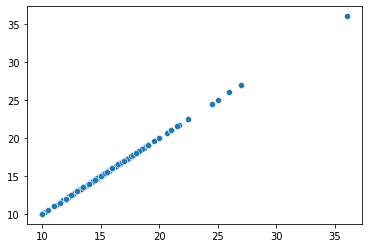

In [52]:


# use the scatterplot function to build the bubble map
sns.scatterplot(x=Y,y=Y, legend=False, sizes=(20, 2000))

# show the graph
plt.show()

(array([[27., 61., 56., 13.,  7.,  1.,  1.,  0.,  0.,  1.],
        [20.,  8.,  4.,  2.,  1.,  1.,  1.,  0.,  0.,  0.],
        [ 2.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([   2. ,  192.2,  382.4,  572.6,  762.8,  953. , 1143.2, 1333.4,
        1523.6, 1713.8, 1904. ]),
 array([10. , 12.6, 15.2, 17.8, 20.4, 23. , 25.6, 28.2, 30.8, 33.4, 36. ]),
 <matplotlib.collections.QuadMesh at 0x7fd3b3adc550>)

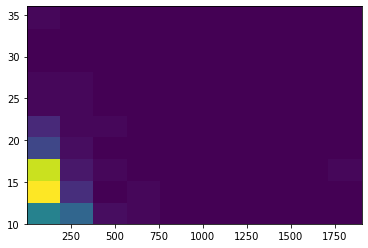

In [53]:
plt.hist2d(X, Y)

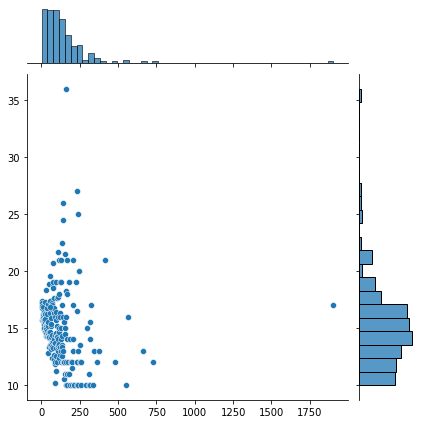

In [54]:
sns.jointplot(x=X, y=Y)

plt.show()

In [55]:
names = ['10-14', '15-19', '20-24', '25-29', '30-34','35-39','40-44','45-49','50-54','55-59','60-64',
         '65-69','70-74','75-79','80-84','85-89','90-94','95+']
d = dict(enumerate(names, 1))

In [59]:
bins = list(range(10,100,5))
group_size_node['node__number_range'] = np.vectorize(d.get)(np.digitize(group_size_node['nNodes'], bins))

/home/alireza.alamgiralem/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
groupSizeAVG = []
for cat in names:
    temp = group_size_node[ group_size_node['node__number_range'] == cat]
    groupSizeAVG.append(np.mean(temp.groupSize))

In [61]:
groupSizeAVG

[9.151964520823228,
 8.366130268199234,
 7.682856107285248,
 7.623385452073419,
 8.160766961651918,
 5.86551724137931,
 4.453333333333333,
 5.243654822335025,
 4.714285714285714,
 4.737704918032787,
 7.186046511627907,
 3.7241379310344827,
 2.95,
 4.290322580645161,
 4.090909090909091,
 10.0,
 6.074074074074074,
 3.3225806451612905]

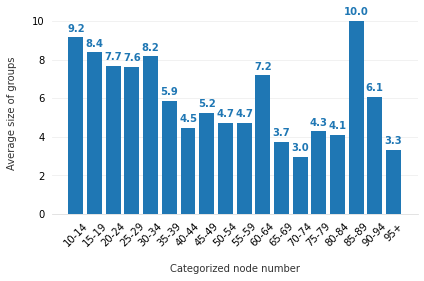

In [63]:
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=names,
    height=groupSizeAVG,
    tick_label=names
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Categorized node number', labelpad=15, color='#333333')
ax.set_ylabel('Average size of groups', labelpad=15, color='#333333')
ax.set_xticklabels(names, rotation=45)


fig.tight_layout()

#fig.savefig("graphs/Barplot_nodeNumber_AvgSizeGroup_ruleBased.pdf", bbox_inches='tight')